## Deep Imbalanced Regression

Deep Imbalanced Regression (DIR) is a framework for learning from imbalanced data with continuous targets, addressing potential missing data for certain target values, and generalizing to the entire target range. This is in contrast to traditional imbalanced classification methods that deal with discrete classes.

Two key challenges in DIR are identified: Label Distribution Smoothing (LDS) and Feature Distribution Smoothing (FDS).

In [2]:
#!pip install import-ipynb
import import_ipynb

In [3]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import loss

importing Jupyter notebook from loss.ipynb


## Data processing

In [51]:
csv_file = 'freMTPL2freq.csv'

df = pd.read_csv(csv_file)
print(df)
df.info()

            IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  \
0             1.0        1   0.10000    D         5       0       55   
1             3.0        1   0.77000    D         5       0       55   
2             5.0        1   0.75000    B         6       2       52   
3            10.0        1   0.09000    B         7       0       46   
4            11.0        1   0.84000    B         7       0       46   
...           ...      ...       ...  ...       ...     ...      ...   
678008  6114326.0        0   0.00274    E         4       0       54   
678009  6114327.0        0   0.00274    E         4       0       41   
678010  6114328.0        0   0.00274    D         6       2       45   
678011  6114329.0        0   0.00274    B         4       0       60   
678012  6114330.0        0   0.00274    B         7       6       29   

        BonusMalus VehBrand   VehGas  Density Region  
0               50      B12  Regular     1217    R82  
1               50      B

change type of data

In [52]:
df['IDpol'] = df["IDpol"].astype(int)
df['Area'] = df["Area"].astype(str)
df['VehBrand'] = df["VehBrand"].astype(str)
df['VehGas'] = df["VehGas"].astype(str)
df['Region'] = df["Region"].astype(str)

check for null values

In [53]:
df.isnull().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

check for unique values

In [54]:
df.nunique()

IDpol         678013
ClaimNb           11
Exposure         187
Area               6
VehPower          12
VehAge            78
DrivAge           83
BonusMalus       115
VehBrand          11
VehGas             2
Density         1607
Region            22
dtype: int64

IDpol is is the same as index, set it as index instead. Also Area code is redundant as we have Region code.

In [55]:
df = df.drop(columns = ['IDpol', 'Area'])
df

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,0.10000,5,0,55,50,B12,Regular,1217,R82
1,1,0.77000,5,0,55,50,B12,Regular,1217,R82
2,1,0.75000,6,2,52,50,B12,Diesel,54,R22
3,1,0.09000,7,0,46,50,B12,Diesel,76,R72
4,1,0.84000,7,0,46,50,B12,Diesel,76,R72
...,...,...,...,...,...,...,...,...,...,...
678008,0,0.00274,4,0,54,50,B12,Regular,3317,R93
678009,0,0.00274,4,0,41,95,B12,Regular,9850,R11
678010,0,0.00274,6,2,45,50,B12,Diesel,1323,R82
678011,0,0.00274,4,0,60,50,B12,Regular,95,R26


In [56]:
df['ClaimFreq'] = df['ClaimNb']/df['Exposure']
df = df.drop(columns = ['Exposure'])
df

,ClaimNb,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimFreq
0,1,5,0,55,50,B12,Regular,1217,R82,10.000000
1,1,5,0,55,50,B12,Regular,1217,R82,1.298701
2,1,6,2,52,50,B12,Diesel,54,R22,1.333333
3,1,7,0,46,50,B12,Diesel,76,R72,11.111111
4,1,7,0,46,50,B12,Diesel,76,R72,1.190476
...,...,...,...,...,...,...,...,...,...,...
678008,0,4,0,54,50,B12,Regular,3317,R93,0.000000
678009,0,4,0,41,95,B12,Regular,9850,R11,0.000000
678010,0,6,2,45,50,B12,Diesel,1323,R82,0.000000
678011,0,4,0,60,50,B12,Regular,95,R26,0.000000


In [57]:
cols = df.columns.tolist()
print(cols)
cols = cols[0:1] + cols[-1:] + cols[1:-1]
print(cols)
df = df[cols]
df

['ClaimNb', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'ClaimFreq']
['ClaimNb', 'ClaimFreq', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']


,ClaimNb,ClaimFreq,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,10.000000,5,0,55,50,B12,Regular,1217,R82
1,1,1.298701,5,0,55,50,B12,Regular,1217,R82
2,1,1.333333,6,2,52,50,B12,Diesel,54,R22
3,1,11.111111,7,0,46,50,B12,Diesel,76,R72
4,1,1.190476,7,0,46,50,B12,Diesel,76,R72
...,...,...,...,...,...,...,...,...,...,...
678008,0,0.000000,4,0,54,50,B12,Regular,3317,R93
678009,0,0.000000,4,0,41,95,B12,Regular,9850,R11
678010,0,0.000000,6,2,45,50,B12,Diesel,1323,R82
678011,0,0.000000,4,0,60,50,B12,Regular,95,R26


In [60]:
df = df.sort_values(by=['ClaimNb'], ascending=False)
df

,ClaimNb,ClaimFreq,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
321248,16,48.484848,4,12,52,50,B1,Regular,824,R91
6539,11,11.000000,5,6,65,50,B2,Diesel,13,R24
488270,11,157.142857,4,13,53,50,B1,Regular,824,R91
487268,11,137.500000,4,13,53,50,B1,Regular,824,R91
321512,9,112.500000,4,12,52,50,B1,Regular,824,R91
...,...,...,...,...,...,...,...,...,...,...
667527,0,0.000000,7,1,39,76,B12,Diesel,155,R93
667470,0,0.000000,9,1,63,50,B12,Regular,476,R82
667469,0,0.000000,9,1,63,50,B12,Regular,476,R82
667468,0,0.000000,4,1,51,50,B12,Regular,1370,R73


## EDA

In [15]:
df['ClaimNb'].describe()

count    678013.000000
mean          0.053247
std           0.240117
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          16.000000
Name: ClaimNb, dtype: float64

In [68]:
claimFreq = df['ClaimFreq']

claimFreq = claimFreq.sort_values(ascending=False)
print(claimFreq)

3360      732.0
4554      732.0
2838      732.0
2267      366.0
2169      366.0
          ...  
190023      0.0
190017      0.0
190024      0.0
190026      0.0
116535      0.0
Name: ClaimFreq, Length: 678013, dtype: float64


histogram and boxplots of features

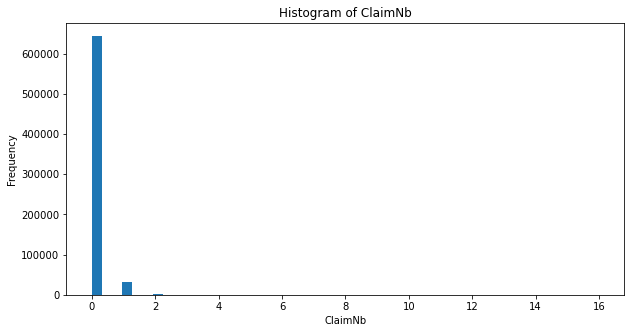

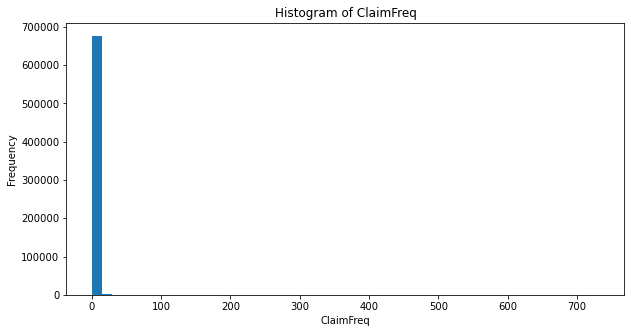

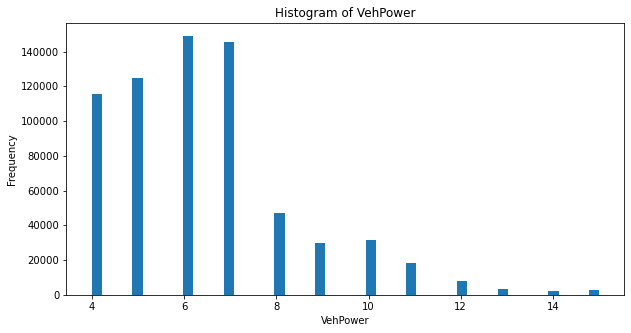

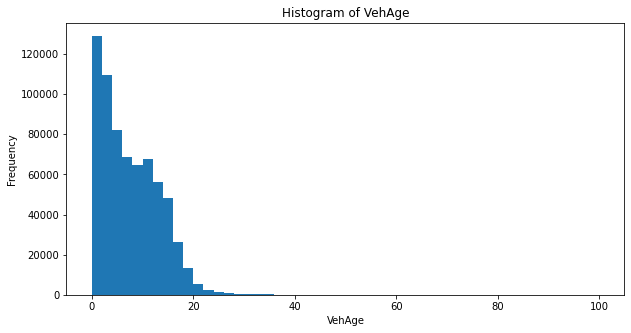

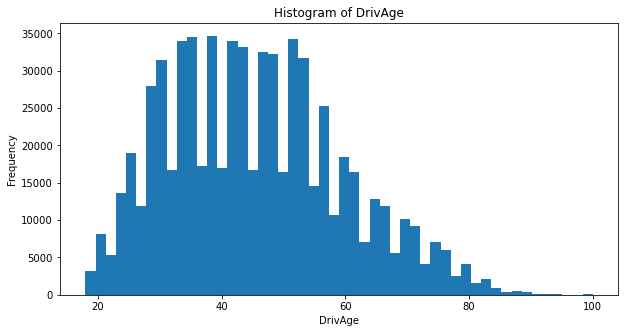

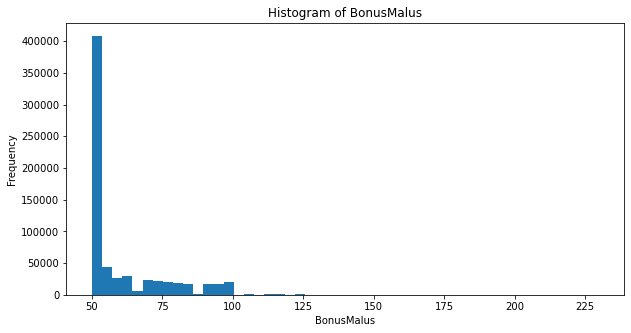

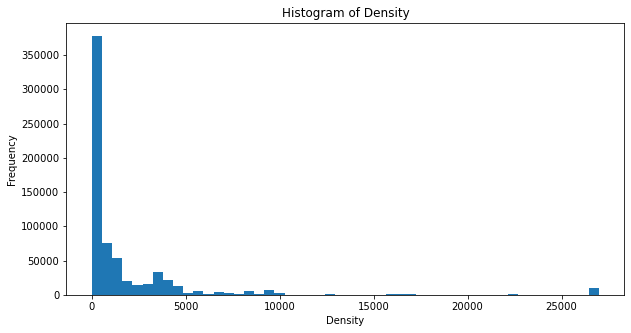

In [87]:
numeric_feature = ['ClaimNb', 'ClaimFreq', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

for feature in numeric_feature:
    plt.figure(figsize=(10, 5))
    plt.hist(df[feature], bins=50)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

bivariate analysis

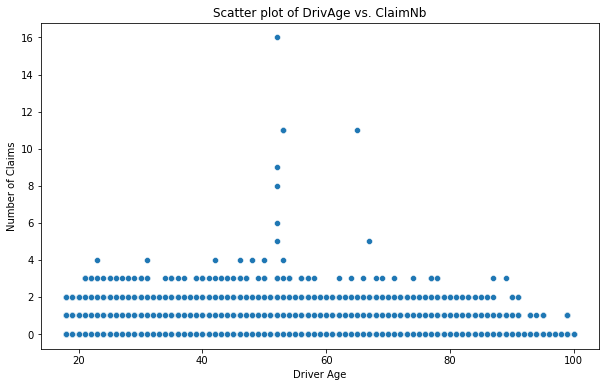

In [96]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DrivAge', y='ClaimNb', data=df)
plt.title('Scatter plot of DrivAge vs. ClaimNb')
plt.xlabel('Driver Age')
plt.ylabel('Number of Claims')
plt.show()


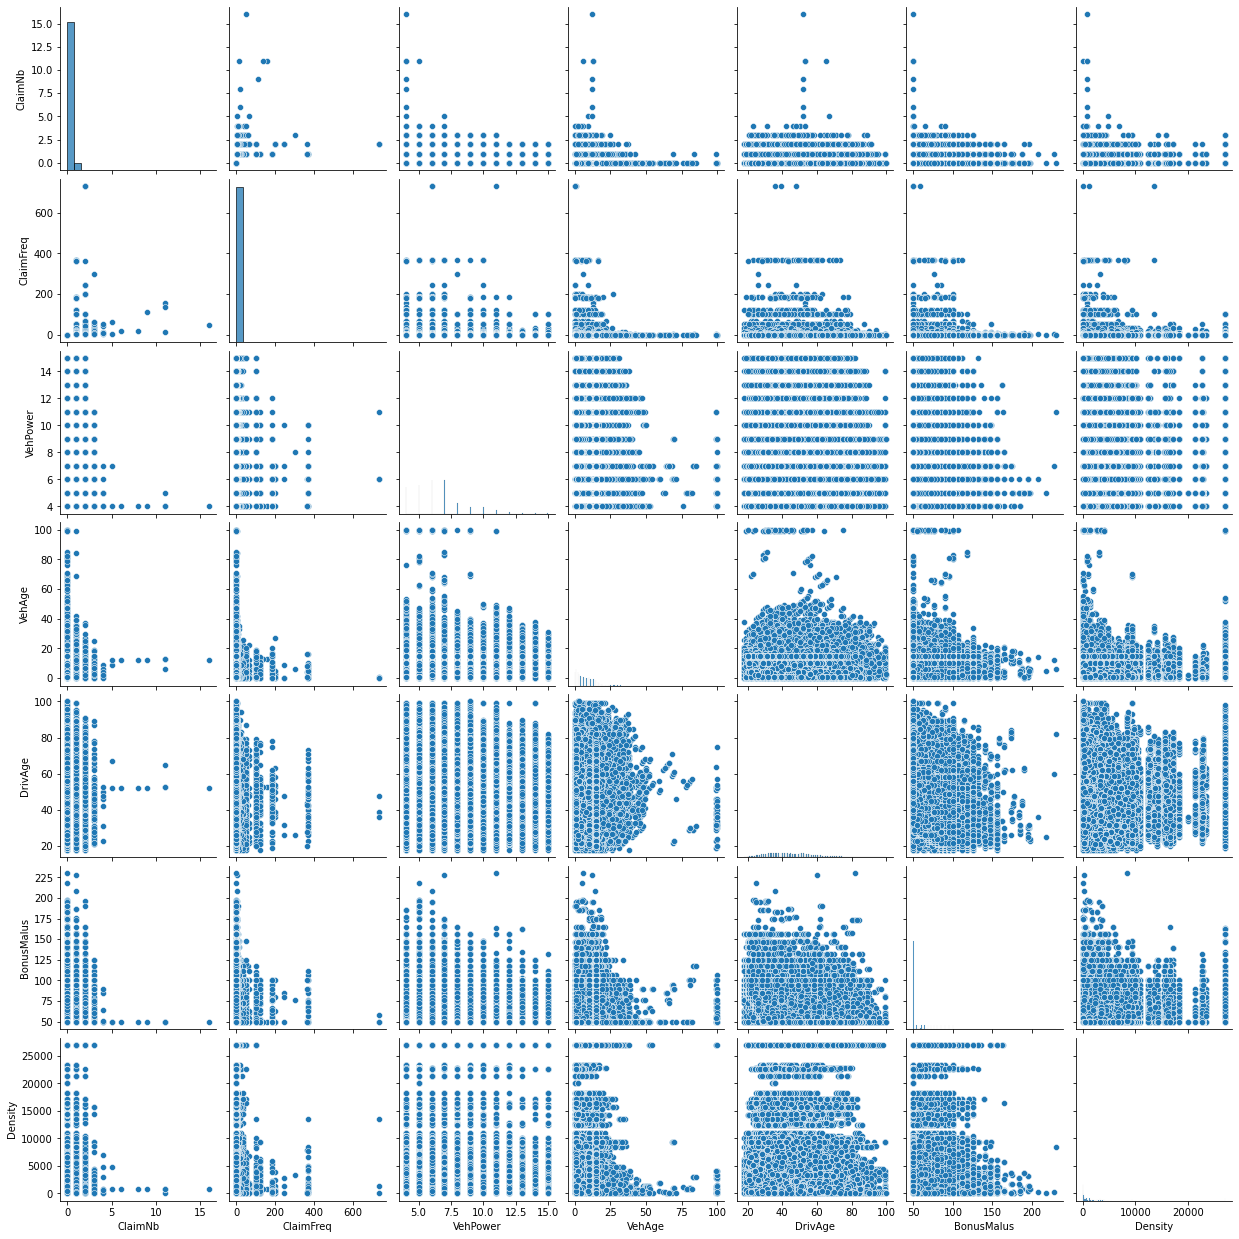

In [97]:
sns.pairplot(df[numeric_feature])
plt.show()

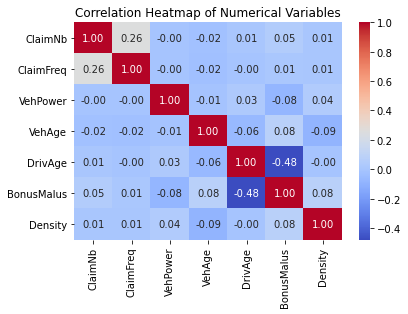

In [100]:
corr_matrix = df[numeric_feature].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

outlier detection

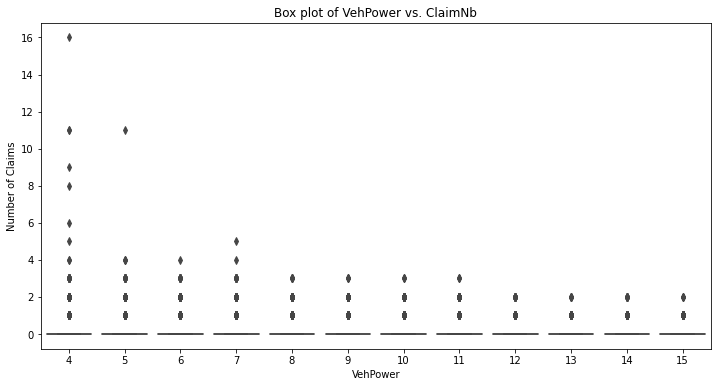

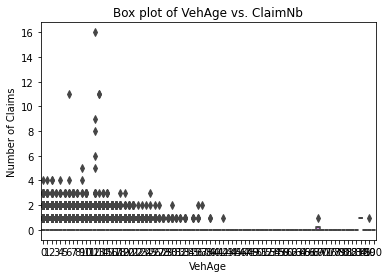

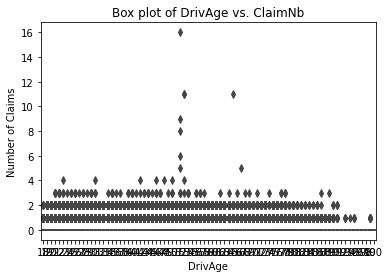

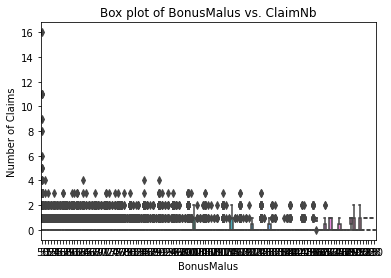

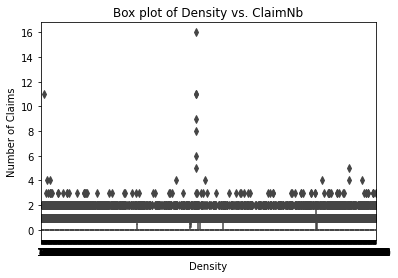

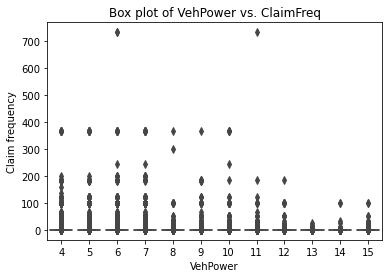

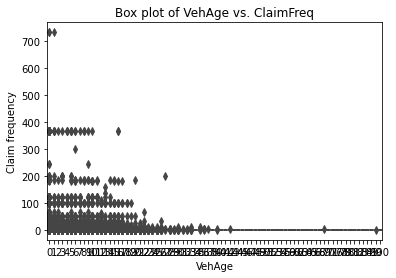

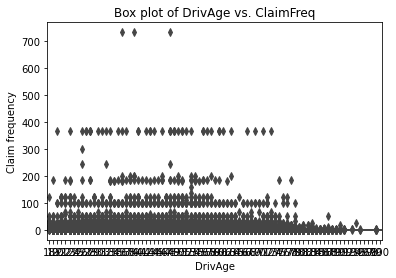

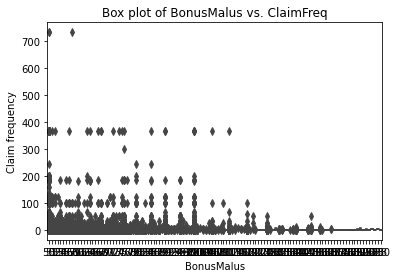

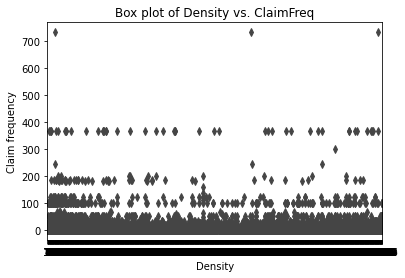

In [103]:
plt.figure(figsize=(12, 6))
comparable_numeric_feature = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

for feature in comparable_numeric_feature:
    sns.boxplot(x=feature, y='ClaimNb', data=df)
    plt.title(f'Box plot of {feature} vs. ClaimNb')
    plt.xlabel(feature)
    plt.ylabel('Number of Claims')
    plt.show()

for feature in comparable_numeric_feature:
    sns.boxplot(x=feature, y='ClaimFreq', data=df)
    plt.title(f'Box plot of {feature} vs. ClaimFreq')
    plt.xlabel(feature)
    plt.ylabel('Claim frequency')
    plt.show()

### Label Distribution Smoothing (LDS)

This technique uses kernel density estimation to smooth the label distribution. It acknowledges the effects of nearby targets, providing an effective label distribution that considers the continuity of labels. LDS is seamlessly integrated with various techniques to enhance DIR performance.

In [1]:
#!pip install utils

In [4]:
from collections import Counter
from scipy.ndimage import convolve1d
from scipy.ndimage import gaussian_filter1d
import numpy as np

def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window


# preds, labels: [Ns,], "Ns" is the number of total samples
preds, labels =678013, range(0, 17),

def get_bin_idx(label):
    bin = 0
    if(label < 5):
        bin = 1
    elif(label < 10):
        bin = 2
    else:
        bin = 3
    return bin

# assign each label to its corresponding bin (start from 0)
# with your defined get_bin_idx(), return bin_index_per_label: [Ns,] 
bin_index_per_label = [get_bin_idx(label) for label in labels]

# calculate empirical (original) label distribution: [Nb,]
# "Nb" is the number of bins
Nb = max(bin_index_per_label) + 1
num_samples_of_bins = dict(Counter(bin_index_per_label))
emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

# lds_kernel_window: [ks,], here for example, we use gaussian, ks=5, sigma=2
lds_kernel_window = get_lds_kernel_window(kernel='gaussian', ks=5, sigma=2)
# calculate effective label distribution: [Nb,]
eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')


In [5]:
from loss import weighted_mse_loss

# Use re-weighting based on effective label distribution, sample-wise weights: [Ns,]
eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
weights = [np.float32(1 / x) for x in eff_num_per_label]

# calculate loss
loss = weighted_mse_loss(preds, labels, weights=weights)

TypeError: unsupported operand type(s) for -: 'int' and 'range'

### Feature Distribution Smoothing (FDS)

 FDS is introduced based on the intuition that continuity in the target space should lead to a corresponding continuity in the feature space. It performs distribution smoothing on the feature space, calibrating potentially biased estimates of feature distribution, especially for underrepresented target values.

In [33]:
!pip install fds

In [36]:
from fds import FDS

config = dict(feature_dim=..., start_update=0, start_smooth=1, kernel='gaussian', ks=5, sigma=2)

def Network(Module):
    def __init__(self, **config):
        super().__init__()
        self.feature_extractor = ...
        self.regressor = nn.Linear(config['feature_dim'], 1)  # FDS operates before the final regressor
        self.FDS = FDS(**config)

    def forward(self, inputs, labels, epoch):
        features = self.feature_extractor(inputs)  # features: [batch_size, feature_dim]
        # smooth the feature distributions over the target space
        smoothed_features = features    
        if self.training and epoch >= config['start_smooth']:
            smoothed_features = self.FDS.smooth(smoothed_features, labels, epoch)
        preds = self.regressor(smoothed_features)
        
        return {'preds': preds, 'features': features}

ImportError: cannot import name 'FDS' from 'fds' (C:\Users\csia7\anaconda3\Lib\site-packages\fds\__init__.py)

In [ ]:
model = Network(**config)

for epoch in range(num_epochs):
    for (inputs, labels) in train_loader:
        # standard training pipeline
        ...

    # update FDS statistics after each training epoch
    if epoch >= config['start_update']:
        # collect features and labels for all training samples
        ...
        # training_features: [num_samples, feature_dim], training_labels: [num_samples,]
        training_features, training_labels = ..., ...
        model.FDS.update_last_epoch_stats(epoch)
        model.FDS.update_running_stats(training_features, training_labels, epoch)